# **Fake Currency Detection**

**1. Import Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import zipfile

**2.Load the Dataset**

In [ ]:
zip_path = "/content/archive.zip"  # Adjust if needed
extract_path = "/content/Indian_Currency_Dataset"

In [ ]:
if os.path.exists(zip_path):
    print(f"ZIP File Found: {zip_path}")

    # Extract only if the folder does not already exist
    if not os.path.exists(extract_path):
        print("Extracting ZIP file... Please wait!")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction Completed Successfully!")
    else:
        print("Files Already Extracted!")
else:
    print(f"Error: ZIP File Not Found at {zip_path}")


ZIP File Found: /content/archive.zip
Files Already Extracted!


In [ ]:
base_dir = "/content/Indian_Currency_Dataset/Indian Currency Dataset"

**3.Define Paths for Train & Test Datasets**

In [ ]:
# Corrected paths
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Check if directories exist
if os.path.exists(train_dir) and os.path.exists(test_dir):
    print("Training and Testing folders found!")
else:
    print("Error: Check the extracted folder structure!")
    print("Available files:", os.listdir("/content/Indian_Currency_Dataset"))


Training and Testing folders found!


**4.Diplay the Classes**

In [ ]:
classes=os.listdir(base_dir)
num_classes=len(classes)
print(f"Number of Classes: {num_classes}")
print(f"Classes: {classes}")

Number of Classes: 2
Classes: ['test', 'train']


**5.No of Images in Dataset**

In [ ]:
# Function to count images in each category
def count_images(directory):
    if not os.path.exists(directory):
        print(f"Directory {directory} not found!")
        return

    categories = os.listdir(directory)
    print(f"\nImage Count in {directory}:")

    for category in categories:
        path = os.path.join(directory, category)
        if os.path.isdir(path):  # Ensure it's a folder
            num_images = len(os.listdir(path))
            print(f"{category}: {num_images} images")

# Count images in train and test sets
count_images(train_dir)
count_images(test_dir)



Image Count in /content/Indian_Currency_Dataset/Indian Currency Dataset/train:
fake: 128 images
real: 120 images

Image Count in /content/Indian_Currency_Dataset/Indian Currency Dataset/test:
fake: 59 images
real: 48 images


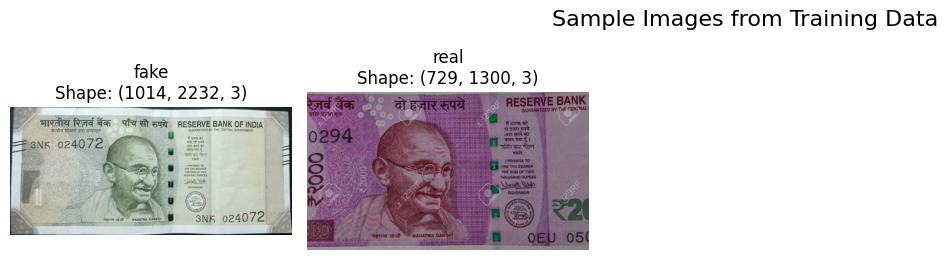

In [ ]:
# Visualize one sample image from each class (up to 10), neatly aligned
num_classes_to_display = min(10, len(os.listdir(train_dir)))
cols = 5
rows = (num_classes_to_display + cols - 1) // cols  # Ceiling division

plt.figure(figsize=(15, rows * 3))

for i, class_name in enumerate(os.listdir(train_dir)[:num_classes_to_display]):
    class_path = os.path.join(train_dir, class_name)
    img_files = os.listdir(class_path)

    if not img_files:
        continue

    img_name = img_files[0]  # Use first image
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f'{class_name}\nShape: {img.shape}')
    plt.axis('off')

plt.suptitle("Sample Images from Training Data", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Define image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
def resize_images(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, IMG_SIZE)  # Resize to 224x224
                    cv2.imwrite(img_path, img)  # Save resized image
                except Exception as e:
                    print(f"Error resizing {img_name}: {e}")

# Resize both train and test images
resize_images(train_dir)
resize_images(test_dir)
print("All images resized successfully!")

All images resized successfully!


**Load Preprocessed Images into Batches**

In [ ]:
# Define parameters
img_size = (224, 224)  # Resize images
batch_size = 32

# Data Augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for test data

# Load images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Fix: One-hot encode labels
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 248 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


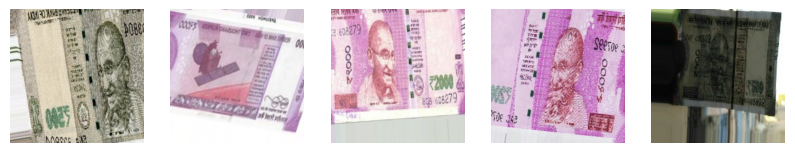

In [ ]:
# Fetch a batch of images
sample_images, sample_labels = next(train_generator)

# Display the first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.axis("off")
plt.show()


**Defining the Model**

In [ ]:
# Define CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(num_classes, activation='softmax')  # Fix: Match output layer with class count
])

cnn_model.summary()  # View model structure


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 20  # Adjust based on results

history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)
cnn_model.save("currency_classification_model.h5")
print("✅ Model saved successfully!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5703 - loss: 3.2476 - val_accuracy: 0.5514 - val_loss: 0.6980
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.5147 - loss: 0.7082 - val_accuracy: 0.5794 - val_loss: 0.6580
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.5632 - loss: 0.6592 - val_accuracy: 0.7103 - val_loss: 0.5985
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.6348 - loss: 0.6481 - val_accuracy: 0.7103 - val_loss: 0.6005
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.6355 - loss: 0.6160 - val_accuracy: 0.5888 - val_loss: 0.5344
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.6027 - loss: 0.5969 - val_accuracy: 0.6168 - val_loss: 0.5452
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.6318 - loss: 0.6236 - val_accuracy: 0.7103 - val_loss: 0.5387
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.6551 - loss: 0.5784 - val_accuracy: 0.6729 - val_loss: 0

✅ Model saved successfully!


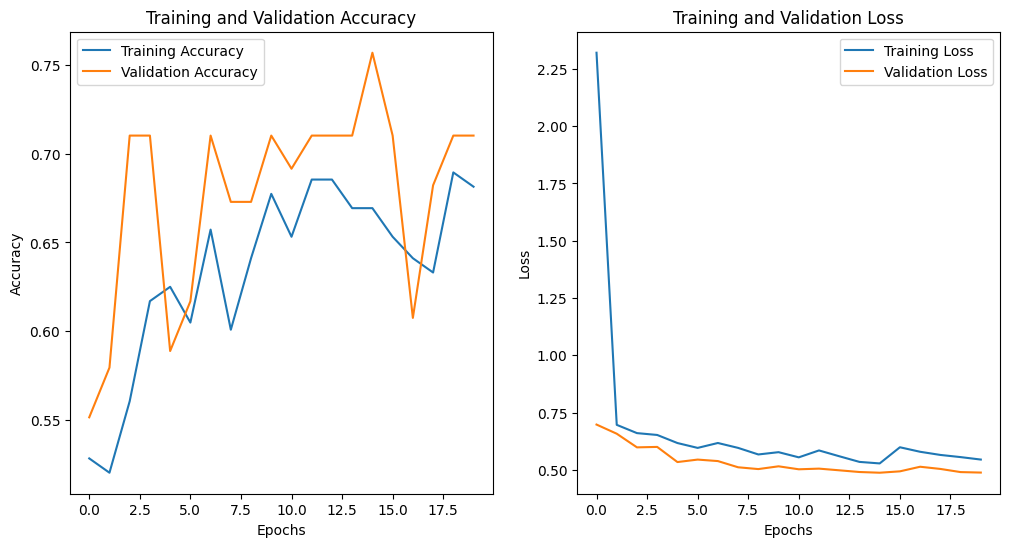

In [ ]:
# Evaluate the model - plotting the training and validation acc/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
val_loss, val_accuracy = cnn_model.evaluate(test_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6789 - loss: 0.4780
Validation Loss: 0.48851776123046875
Validation Accuracy: 0.7102803587913513
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7091 - loss: 0.4933
✅ Test Accuracy: 71.03%


**Train the Model**

In [ ]:
# Import plotting library
import matplotlib.pyplot as plt

# Extract training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Epoch range
epochs_range = range(len(train_accuracy))


In [ ]:
test_path = "/content/Indian_Currency_Dataset/Indian Currency Dataset/test"
test_images = [os.path.join(root, f)
               for root, _, files in os.walk(test_path)
               for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img in test_images:
    print(img)


/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (35).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (27).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (39).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (50).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/wqeqwerqwerq.png
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (33).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (16).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (11).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (26).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (37).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/test (20).jpg
/content/Indian_Currency_Dataset/Indian Currency Dataset/test/fake/ss.jpg
/content/Indian_Currency_Dataset

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load an image for testing
img_path = "/content/Indian_Currency_Dataset/Indian Currency Dataset/test/real/test (24).jpg"  # Change to your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
predictions = cnn_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

class_labels = list(train_generator.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: real
